In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

# import mne
import numpy as np
# from copy import deepcopy
# import matplotlib.pyplot as plt
import sys; sys.path.insert(0, '../')
from esinet import util
from esinet import Simulation
from esinet import Net
from esinet.forward import create_forward_model, get_info
from scipy.stats import pearsonr
from matplotlib import pyplot as plt
plot_params = dict(surface='white', hemi='both', verbose=0)

## Create Forward model
First we create a template forward model which comes with the esinet package

In [2]:
info = get_info(sfreq=100, kind="biosemi64")
fwd = create_forward_model(sampling="ico3", info=info)
_, pos = util.unpack_fwd(fwd)[1:3]
leadfield = fwd["sol"]["data"]
n_chans, n_dipoles = leadfield.shape

import mne
from scipy.sparse.csgraph import laplacian

adjacency = mne.spatial_src_adjacency(fwd['src']).toarray()
laplace_operator = abs(laplacian(adjacency))

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    2.1s remaining:    3.5s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    2.1s remaining:    1.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    2.1s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.1s remaining:    0.0s


-- number of adjacent vertices : 1284


[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.1s finished


# Defs

In [3]:
def prep_data(X, y):
    X = np.stack([(x - np.mean(x)) / np.std(x) for x in X], axis=0)
    y = np.stack([(x / np.max(abs(x))) for x in y], axis=0)
    return X, y

# Simulate

In [112]:
settings = dict(duration_of_trial=0.25, extents=(1,40), number_of_sources=(1,15), target_snr=1e99)
sim = Simulation(fwd, info, settings=settings).simulate(n_samples=2)
X = np.stack([eeg.average().data for eeg in sim.eeg_data], axis=0)
y = np.stack([source.data for source in sim.source_data], axis=0)
X, y = prep_data(X, y)
X = np.swapaxes(X, 1, 2)
y = np.swapaxes(y, 1, 2)
sim.source_data[0].plot(**plot_params)

Simulating data based on sparse patches.


100%|██████████| 2/2 [00:00<00:00, 71.42it/s]


# Model

## Create

In [113]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, InputLayer, Input, Lambda, LayerNormalization, GRU, multiply, Bidirectional
from tensorflow.keras.layers import Activation, Dropout, ActivityRegularization, TimeDistributed, Reshape, Permute, GaussianNoise, add
import numpy as np
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model
# import tensorflow_probability as tfp
from tensorflow.keras.regularizers import l1, l2, l1_l2
K.set_image_data_format('channels_last')

def data_loss(leadfield, lam_0=0.1):
    leadfield_ = tf.cast(leadfield, dtype=tf.float32)
    def batch_data_loss(y_true, y_est):
        def d_loss(y_true, y_est):
            y_true_eeg = tf.transpose(tf.matmul(leadfield_, tf.transpose(y_true)))
            y_est_eeg = tf.transpose(tf.matmul(leadfield_, tf.transpose(y_est)))
            # print("y_true ", y_true)
            # print("y_est ", y_est)
            
            error_source = tf.keras.losses.CosineSimilarity(name="Data_Cosine_Loss")(y_est, y_true)
            error_eeg = tf.keras.losses.CosineSimilarity(name="Data_Cosine_Loss")(y_est_eeg, y_true_eeg)
            # error_source =  K.mean(K.square(y_est - y_true))
            # error_eeg =  K.mean(K.square(y_est_eeg - y_true_eeg))
            
            return (error_source*lam_0 + error_eeg) / (1 + lam_0)
        
        

        batched_losses = tf.map_fn(lambda x:
            d_loss(x[0], x[1]), 
            (y_true, y_est), dtype=tf.float32)
        return K.mean(batched_losses)


    return batch_data_loss


def consistency(x):
    return K.mean(K.std(K.abs(x), axis=1))

# def consistency(source):
#     def c_loss(x):
#         matrix = compute_cosine_distances(K.abs(x), K.abs(x))
#         return K.mean(matrix)


#     batched_losses = tf.map_fn(lambda x:
#             c_loss(x), 
#             source, dtype=tf.float32)
#     return K.mean(batched_losses)

def get_distances(a, b):  # L2
    # print("tracing get_distances")
    normalize_a = tf.nn.l2_normalize(a,-1)        
    normalize_b = tf.nn.l2_normalize(b,-1)        

    return K.sqrt(K.sum(K.square(tf.expand_dims(normalize_a, 0) - tf.expand_dims(normalize_b, 1)), axis=-1))

# def c_loss(source):
#     batched_losses = tf.map_fn(lambda x:
#             get_distances(x, x), 
#             source, fn_output_signature=tf.float32, dtype=tf.float32)
#     return K.mean(batched_losses)


def compute_cosine_distances(a, b):
    # x shape is n_a * dim
    # y shape is n_b * dim
    # results shape is n_a * n_b

    normalize_a = tf.nn.l2_normalize(a,-1)        
    normalize_b = tf.nn.l2_normalize(b,-1)
    distance = 1 - tf.matmul(normalize_a, normalize_b, transpose_b=True)
    return distance


def c_loss(sources):
    matrix = compute_cosine_distances(K.abs(sources), K.abs(sources))
    return K.mean(K.square(matrix))

def l1_sparsity(x):
    return K.mean(K.abs(x)) 
    # return K.mean(K.pow(K.abs(x), 0.5))
    
def temporal_reg(x):
    return K.mean(K.square(K.std(K.abs(x), axis=1)))

def get_model(name="Model", n_dense_layers=2, n_lstm_units=64, hidden_units=200, learning_rate=0.001, lam_0=0., lam_1=1, lam_2=0.001, lam_3=1, add_consistency=True):
    input_shape = (None, n_chans)
    leadfield_ = tf.cast(leadfield, dtype=tf.float32)

    inputs = tf.keras.Input(shape=input_shape, name=name)

    fc = TimeDistributed(Dense(hidden_units, activation="linear", name="FC1"))(inputs)
    source = TimeDistributed(Dense(n_dipoles, activation="linear", name="Output_Final"))(fc)

    gru = Bidirectional(GRU(n_lstm_units, return_sequences=True, name='GRU_Discriminator'))(inputs)
    source_time = TimeDistributed(Dense(n_dipoles, activation="sigmoid", name="Mask"))(gru)


    out = multiply([source_time, source])
    # out = Lambda(lambda x: tf.transpose(tf.linalg.matmul(leadfield_, tf.transpose(x))), output_shape=(None, n_chans))(source)
    # # out = TimeDistributed(Lambda(lambda x: tf.transpose(tf.linalg.matmul(leadfield_, tf.transpose(x))), output_shape=(None, n_chans)))(source)
    
    
    model = tf.keras.Model(inputs=inputs, outputs=out, name=name)
    
    # Data Loss
    # L1 Loss
    # print("out: ", out)
    model.add_loss(l1_sparsity(out)*lam_1)
    model.add_loss(temporal_reg(out)*lam_3)
    # Data consistency loss
    if add_consistency:
        model.add_loss(c_loss(out)*lam_2)
    
    model.compile(loss=data_loss(leadfield, lam_0=lam_0), optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))
    # model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))
    
    return model



## Train

In [119]:
lams_0 = [0.0, 0.0]  # source-based
lams_1 = [0.1, 0.1]  # sparsity
lams_2 = [0, 1]  # context
lams_3 = [0, 0]  # temporal regularization

y_ = np.zeros(y.shape[1:])
callbacks = [tf.keras.callbacks.EarlyStopping(patience=300, min_delta=0.01, monitor="loss", restore_best_weights=True)]

models = []
for lam_0, lam_1, lam_2, lam_3 in zip(lams_0, lams_1, lams_2, lams_3):
    model = get_model(lam_0=lam_0, lam_1=lam_1, lam_2=lam_2, lam_3=lam_3, name=f"Lam_{lam_1}")
    model.fit(X[0][np.newaxis], y[0][np.newaxis], epochs=10000, batch_size=8, callbacks=callbacks, verbose=0)
    print(model.name)
    models.append(model)

## Evaluate

No projector specified for this dataset. Please consider the method self.add_proj.


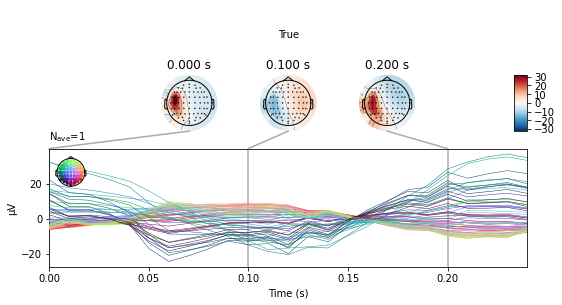

No projector specified for this dataset. Please consider the method self.add_proj.


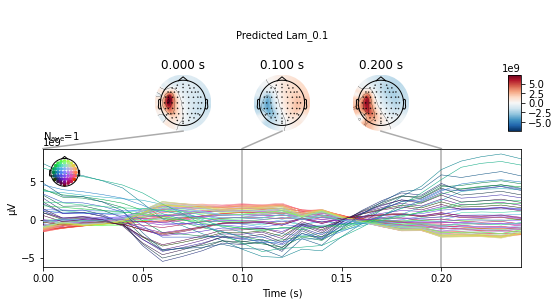

AUC:  0.6219177725034998  Corrs:  0.2497604180960479  nMSE:  0.019252964640734373
No projector specified for this dataset. Please consider the method self.add_proj.


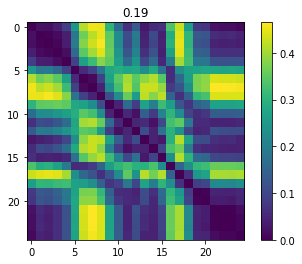

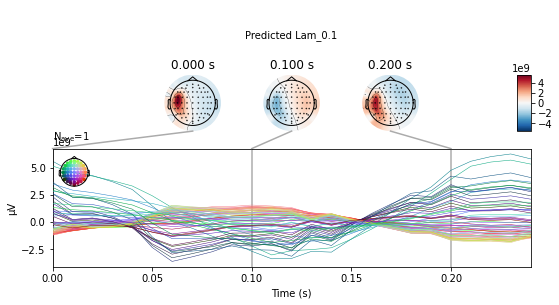

AUC:  0.6239471319928189  Corrs:  0.15454533310407567  nMSE:  0.0172677134667307


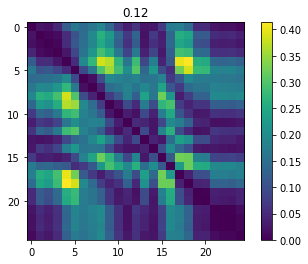

In [115]:
from esinet.evaluate import eval_auc
from scipy.stats import pearsonr
idx = 0
stc = sim.source_data[idx].copy()
stc.plot(**plot_params)
evoked = sim.eeg_data[idx].average()
evoked.plot_joint(title="True", times=[0, 0.10, 0.20])
for mod in models:
    src_hat = mod.predict(X)[idx]
    stc_hat = stc.copy()
    stc_hat.data = src_hat.T
    stc_hat.plot(**plot_params, brain_kwargs=dict(title=mod.name))

    evoked_ = util.get_eeg_from_source(stc_hat, fwd, info, tmin=evoked.tmin)
    evoked_.plot_joint(title=f"Predicted {mod.name}", times=[0, 0.10, 0.20])


    auc = np.mean([np.mean(eval_auc(y_true_sample, y_pred_sample, pos)) for y_true_sample, y_pred_sample in zip(stc.data.T, stc_hat.data.T)])
    corrs = np.mean([np.mean(pearsonr(y_true_sample, y_pred_sample)[0]) for y_true_sample, y_pred_sample in zip(stc.data.T, stc_hat.data.T)])
    nmses = np.mean([np.mean((y_true_sample - y_pred_sample)**2) for y_true_sample, y_pred_sample in zip(stc.data.T, stc_hat.data.T)])
    
    print("AUC: ", auc, " Corrs: ", corrs, " nMSE: ", nmses)
    mat = compute_cosine_distances(abs(stc_hat.data.T), abs(stc_hat.data.T)).numpy()
    plt.figure()
    plt.imshow(mat)
    plt.colorbar()
    plt.title(f"{mat.mean():.2f}")

tf.Tensor(0.050106023, shape=(), dtype=float32)
tf.Tensor(0.014489409, shape=(), dtype=float32)
tf.Tensor(0.02273479, shape=(), dtype=float32)


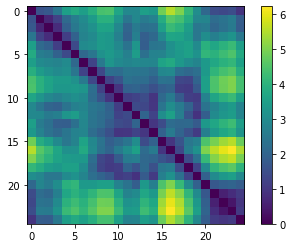

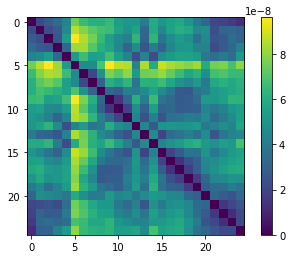

In [118]:
from scipy.spatial.distance import cdist

print(l1_sparsity( src_hat ))
print(temporal_reg( src_hat ))
print(c_loss( src_hat ))

plt.figure()
plt.imshow(cdist(abs(src_hat), abs(src_hat)))
plt.colorbar()

plt.figure()
plt.imshow(cdist(abs(stc.data.T), abs(stc.data.T)))
plt.colorbar()

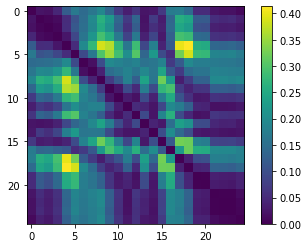

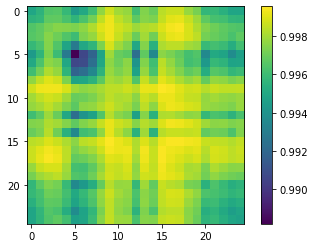

Using control points [0.24574659 0.44386096 1.3369309 ]
Using control points [0.31661304 0.61268991 1.33127289]


In [117]:
plt.figure()
plt.imshow(compute_cosine_distances(abs(stc_hat.data.T), abs(stc_hat.data.T)).numpy())
plt.colorbar()

plt.figure()
plt.imshow(compute_cosine_distances(abs(stc.data.T), abs(stc.data.T)).numpy())
plt.colorbar()

In [91]:
sys.path.insert(0, '../../invert/')
from invert.solvers.minimum_norm_estimates import SolverDynamicStatisticalParametricMapping, SolverMinimumNorm
from invert.solvers.wrop import SolverLAURA
from invert.solvers.empirical_bayes import SolverChampagne

# solver = SolverLAURA().make_inverse_operator(fwd)
solver = SolverChampagne().make_inverse_operator(fwd)
# solver = SolverMinimumNorm().make_inverse_operator(fwd)

stc_mne = solver.apply_inverse_operator(sim_test.eeg_data[0].average())
stc_mne.data = stc_mne.data / np.max(abs(stc_mne.data))
stc_mne.plot(**plot_params, brain_kwargs=dict(title=solver.name))
auc = np.mean([np.mean(eval_auc(y_true_sample, y_pred_sample, pos)) for y_true_sample, y_pred_sample in zip(stc.data.T, stc_mne.data.T)])
corrs = np.mean([np.mean(pearsonr(y_true_sample, y_pred_sample)[0]) for y_true_sample, y_pred_sample in zip(stc.data.T, stc_mne.data.T)])
nmses = np.mean([np.mean((y_true_sample - y_pred_sample)**2) for y_true_sample, y_pred_sample in zip(stc.data.T, stc_mne.data.T)])

print(model.name, " AUC: ", auc, " Corrs: ", corrs, " nMSE: ", nmses, "\n")

CS_Net  AUC:  0.6901205204081633  Corrs:  0.25001445685071416  nMSE:  0.0013093190564428994 



Using control points [0.2380896  0.26938491 0.61941261]
